In [1]:
import glob
import os
import xarray as xr
import xoak
import pandas as pd
import matplotlib.pyplot as plt
import nctoolkit as nc
import numpy as np

import rioxarray as rioxr
from rasterio.enums import Resampling
import geopandas as gpd
import fiona 
fiona.drvsupport.supported_drivers['KML'] = 'rw'

import seaborn as sns
nc.deep_clean()

nctoolkit is using Climate Data Operators version 2.1.0


Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).


In [2]:
new_user=False

# Read in Upper East River Polygon

In [4]:
# Polygon for Upper East River
upper_east_river_poly = gpd.read_file('../multisite/polygons/east_polygon.json')
upper_east_river_area = upper_east_river_poly.area # m^2

# Iterate through folders to create a climatology dataset for ET

In [5]:
if new_user:
    # Get names of each WRF folder
    wrf_file_location = '/storage/dlhogan/sos/data/WRF'
    wrf_folders = os.listdir(wrf_file_location)

    # Pull in SNTL data
    er_sntl_data = xr.open_dataset('/storage/dlhogan/sos/data/east_river_sntl_20220930.nc')

    # Set constant values for latent heat of sublimation and latent heat of evaporation
    Lv = 2.501e6 # J kg-1
    Ls = 2.834e6 # J kg-1

    et_rate_ds_list = []

    for year in wrf_folders:
        # print year
        print(f'Working on {year}')
        # Get WY snow melt date
        yr = int(year[2:])
        snow_wteq_daily = er_sntl_data.sel(Location='Butte_380:CO:SNTL').where(er_sntl_data.WY==yr)['WTEQ']

        snow_on_date = snow_wteq_daily.where(snow_wteq_daily>0).dropna(dim='Date').to_dataframe().index[0]
        snow_off_date = snow_wteq_daily.sel(Date=slice(f'{yr}-01-01',f'{yr}-09-30')).where((snow_wteq_daily==0)).idxmin().values

        tmp_ds = xr.open_mfdataset(f'{wrf_file_location}/{year}/*.nc')
        # Creates a mask to mask out aboe and below freezing conditions
        below_freezing_mask = ((tmp_ds.where(tmp_ds.EAST_MASK==True)['T2'] <= 273.15) &
                        (tmp_ds.where(tmp_ds.EAST_MASK==True).XTIME >= snow_on_date) & 
                        (tmp_ds.where(tmp_ds.EAST_MASK==True).XTIME < snow_off_date) ) 

        above_freezing_mask = ((tmp_ds.where(tmp_ds.EAST_MASK==True)['T2'] > 273.15) &
                        (tmp_ds.where(tmp_ds.EAST_MASK==True).XTIME < snow_on_date) | 
                        (tmp_ds.where(tmp_ds.EAST_MASK==True).XTIME >= snow_off_date) ) 
        # Compute daily sublimation/evaporation rates
        sublimation = tmp_ds.where(below_freezing_mask).LH/Ls * 3600 * 24
        evaporation = tmp_ds.where(above_freezing_mask).LH/Lv * 3600 * 24

        # Combine these two into one dataset
        et_hourly = xr.merge([sublimation,evaporation])
        et_hourly = et_hourly.rename_vars({'LH':'ET_rate'})

        # Compute monthly basin means

        et_monthly = ((et_hourly).resample(XTIME='1M')).mean()

        month_multiplier = xr.DataArray(
                                        np.array([30,28,31,30,31,30,31,31,30,31,30,31]),
                                        dims=['XTIME'],
                                        coords=[et_monthly.XTIME.values],)

        et_monthly = et_monthly * month_multiplier
        
        et_monthly['ET_rate'] = et_monthly.ET_rate.assign_attrs({"units":"mm/month"})
        et_monthly['ACCPRCP'] = tmp_ds['ACCPRCP'].resample(XTIME='1M').mean()
        et_monthly['ACCPRCP'] = et_monthly.ACCPRCP.assign_attrs({"units":"mm/month"})
        et_monthly['EAST_MASK']=tmp_ds['EAST_MASK'].resample(XTIME='1M').mean()
        # Append result to list
        et_rate_ds_list.append(et_monthly)
        print('Done!')
    print('Finished!')

    wrf_climatology_ds = xr.concat(et_rate_ds_list,dim='XTIME')
    # wrf_climatology_ds.to_netcdf('/storage/dlhogan/sos/data/wrf_climatology.nc')

### Pull in WRF climaotology monthly averages

In [6]:
wrf_climatology_ds = xr.open_dataset('/storage/dlhogan/sos/data/wrf_climatology.nc')
# Adding WY
wrf_climatology_ds = wrf_climatology_ds.assign_coords({'WY':wrf_climatology_ds.XTIME.dt.year.where(wrf_climatology_ds.XTIME.dt.month < 10, wrf_climatology_ds.XTIME.dt.year + 1)})


# WRF climatology adding in precipitation

In [ ]:
# Month order for water years
months = [10,11,12,1,2,3,4,5,6,7,8,9]
# Each year within the wrf dataset
years = wrf_climatology_ds.WY.groupby(wrf_climatology_ds.WY).mean().values

# 
for i,wy in enumerate(wrf_climatology_ds.WY.groupby(wrf_climatology_ds.WY).mean().values):
    precip = [10,11,12,1,2,3,4,5,6,7,8,9]
    precip[0] = wrf_climatology_ds.where((wrf_climatology_ds.WY==wy) & (wrf_climatology_ds.XTIME.dt.month==10)).ACCPRCP.dropna(dim='XTIME').squeeze()
    precip[1:] = wrf_climatology_ds.where(wrf_climatology_ds.WY==wy).ACCPRCP.diff(dim='XTIME').dropna(dim='XTIME')
    if i == 0:
        monthly_precip_ds = xr.concat(precip, dim='XTIME')
    else:
        monthly_precip_ds = monthly_precip_ds.combine_first(xr.concat(precip, dim='XTIME'))

wrf_climatology_ds['precip'] = monthly_precip_ds
# wrf_climatology_ds.to_netcdf('/storage/dlhogan/sos/data/wrf_climatology_precip.nc')

# Monthly Standardized Anomaly Climatology

In [7]:
# Load in wrf_climatology netcdf 
wrf_climatology_ds = xr.open_dataset('/storage/dlhogan/sos/data/wrf_climatology_precip.nc')
wrf_climatology_ds = wrf_climatology_ds.where(wrf_climatology_ds['EAST_MASK']==True)
# Get monthly normalized values of sublimation/evaporation and precipitation
wrf_climatology_mean_ds = wrf_climatology_ds.groupby('XTIME.month').mean("XTIME")
wrf_climatology_std_ds = wrf_climatology_ds.groupby('XTIME.month').std("XTIME")


stand_anomalies = xr.apply_ufunc(
    lambda x,m,s: (x-m)/s,
    wrf_climatology_ds.groupby("XTIME.month"),
    wrf_climatology_mean_ds,
    wrf_climatology_std_ds,
    dask='parallelized'
)

Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <= 0 for slice.
Degrees of freedom <

### Create standardized anomalies for mean basin conditions

In [9]:
stand_anaomalies_et = stand_anomalies['ET_rate'].mean(dim=['south_north','west_east']).compute()
stand_anaomalies_precip = stand_anomalies['precip'].mean(dim=['south_north','west_east']).compute()

### Create dataframes from the standardized anomalies

In [10]:
stand_anaomalies_et_df = stand_anaomalies_et.to_dataframe()
stand_anaomalies_precip_df = stand_anaomalies_precip.to_dataframe()

In [11]:
# export standardized anomalies to csv
# stand_anaomalies_et_df = stand_anaomalies_et_df.to_csv('/storage/dlhogan/sos/data/wrf_stand_anom_et.csv')
# stand_anaomalies_precip_df = stand_anaomalies_precip_df.to_csv('/storage/dlhogan/sos/data/wrf_stand_anom_precip.csv')

### Plot up climatological anomalies for precipitation and ET rate 

In [12]:
stand_anaomalies_et_df['wy'] = stand_anaomalies_et_df.index.year.where(stand_anaomalies_et_df.index.month < 10, stand_anaomalies_et_df.index.year + 1).values
stand_anaomalies_precip_df['wy'] = stand_anaomalies_precip_df.index.year.where(stand_anaomalies_precip_df.index.month < 10, stand_anaomalies_precip_df.index.year + 1).values
tmp = []
idx = np.array([10,11,12,1,2,3,4,5,6,7,8,9])
for year in stand_anaomalies_et_df['wy'].unique():
    a = stand_anaomalies_et_df[stand_anaomalies_et_df['wy'] == year]['ET_rate']
    a = a.groupby(a.index.month).mean()
    a = a[idx]
    a.name=year
    tmp.append(a)
et_anomaly_df = pd.concat(tmp, axis=1).T

tmp=[]
for year in stand_anaomalies_precip_df['wy'].unique():
    a = stand_anaomalies_precip_df[stand_anaomalies_et_df['wy'] == year]['precip']
    a = a.groupby(a.index.month).mean()
    a = a[idx]
    a.name=year
    tmp.append(a)
precip_anomaly_df = pd.concat(tmp, axis=1).T


Text(0.5, 1.0, 'Precip Normalized Anomaly (WRF 1km )')

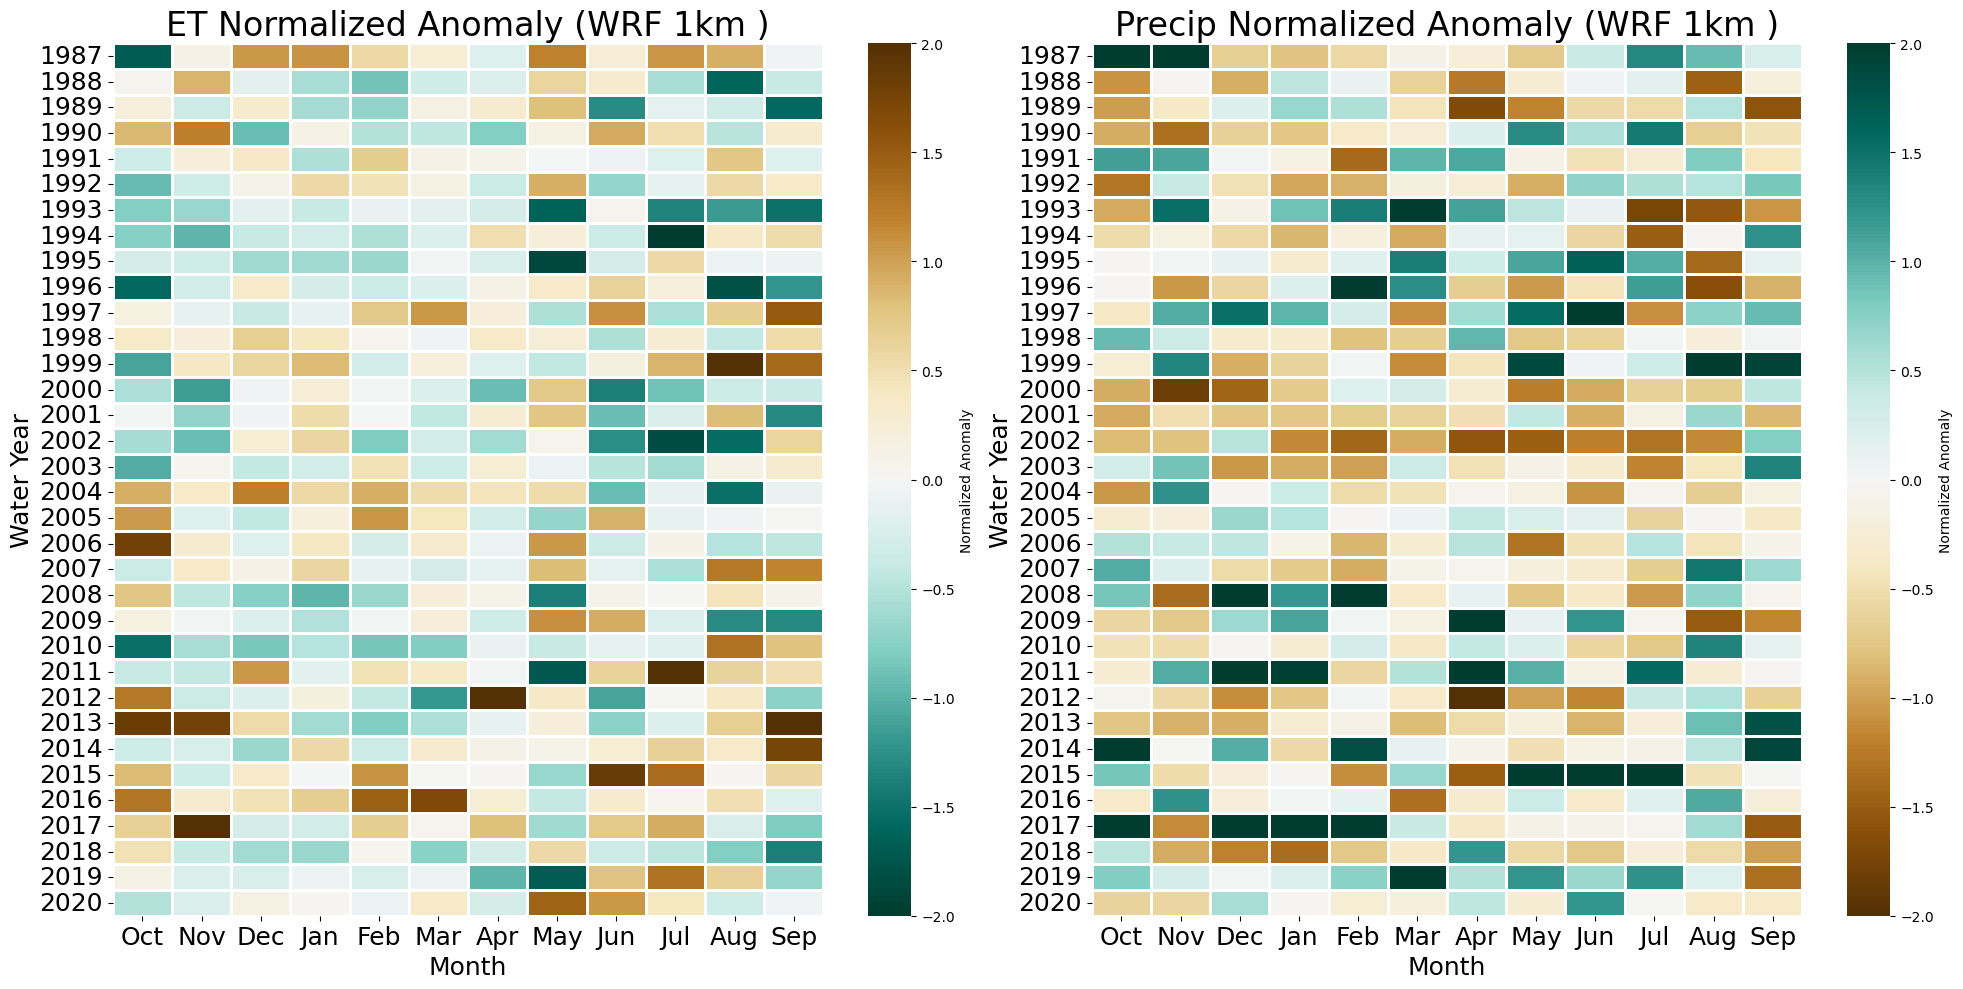

In [13]:
fig, axs=plt.subplots(ncols=2,figsize=(20,10), facecolor='w',tight_layout=True)

months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
sns.heatmap(et_anomaly_df, cmap='BrBG_r', vmin=-2, vmax=2,linewidths=2, cbar_kws={'label':'Normalized Anomaly'}, ax=axs[0])
axs[0].set_yticklabels(et_anomaly_df.index, rotation=0, ha='right', size=18);
axs[0].set_xticklabels(months, rotation=0, ha='center', size=18);
axs[0].set_xlabel('Month',size=18)
axs[0].set_ylabel('Water Year', size=18)
axs[0].set_title('ET Normalized Anomaly (WRF 1km )', size=24)

sns.heatmap(precip_anomaly_df, cmap='BrBG', vmin=-2, vmax=2,linewidths=2, cbar_kws={'label':'Normalized Anomaly'}, ax=axs[1])
axs[1].set_yticklabels(precip_anomaly_df.index, rotation=0, ha='right', size=18);
axs[1].set_xticklabels(months, rotation=0, ha='center', size=18);
axs[1].set_xlabel('Month',size=18)
axs[1].set_ylabel('Water Year', size=18)
axs[1].set_title('Precip Normalized Anomaly (WRF 1km )', size=24)

In [15]:
# Coordinated for Gothic, CO
gothic_coords  = [38.959158, -106.9897676]

import datetime as dt

# Climatorology including precipitation, snowfall and temperature for each month
bb_climatology = pd.read_csv('../../data/billy_barr_monthly_avg.csv',sep='\t')
bb_climatology[bb_climatology==" "] = np.nan
bb_climatology['WY'] = [int(str(year)[0:2]+str(year)[4:]) for year in bb_climatology['Year']]
bb_climatology['water_cm'] = bb_climatology['water_cm'].astype(float)
dates = pd.to_datetime([f"{bb_climatology.loc[i,'WY']}-{bb_climatology.loc[i,'Month']}-01" for i in bb_climatology.index], format='%Y-%m-%d')
date_list=[]

for i,date in enumerate(dates):
    if date.year == 1900:
        date = dt.date(2000,date.month,date.day)
    if date.month in [9,10,11,12]:
        date = dt.date(date.year-1,date.month,date.day)
    else:
        date = dt.date(date.year,date.month,date.day)
    date_list.append(date)
bb_climatology.index=date_list
bb_climatology = bb_climatology.drop(['Month', 'Year'], axis=1)
for col in bb_climatology:
    bb_climatology[col] = bb_climatology[col].astype(float)


# Monthly snowfall going back to WY 1974
bb_snowfall = pd.read_csv('../../data/billy_barr_snowfall.csv', sep='\s+')
bb_snowfall = bb_snowfall.set_index('WY')

# Monthly accumulated precipitation going back to 1974 (for winter) and 1990 for all years
bb_monthly_precip = pd.read_csv('../../data/billy_barr_total_monthly_P.csv', sep='\s+')
bb_monthly_precip = bb_monthly_precip.replace(-9999.,np.nan)
bb_monthly_precip = bb_monthly_precip.set_index('WY')
bb_monthly_precip.rename(index={1900:2000},inplace=True)
bb_monthly_precip = bb_monthly_precip[[c for c in bb_monthly_precip  if c not in ['Sept']]
       + ['Sept']]
sept_list = (bb_monthly_precip['Sept'].to_list()[1:])
sept_list.append(1.59)
bb_monthly_precip['Sept'] = sept_list


In [16]:
bb_precip_anomaly = bb_monthly_precip.copy()

for col in bb_precip_anomaly.columns:
    bb_precip_anomaly[col] = (bb_precip_anomaly[col]-bb_precip_anomaly[col].mean())/bb_precip_anomaly[col].std()

Text(0.5, 1.0, 'billy barr Precip Normalized Anomaly')

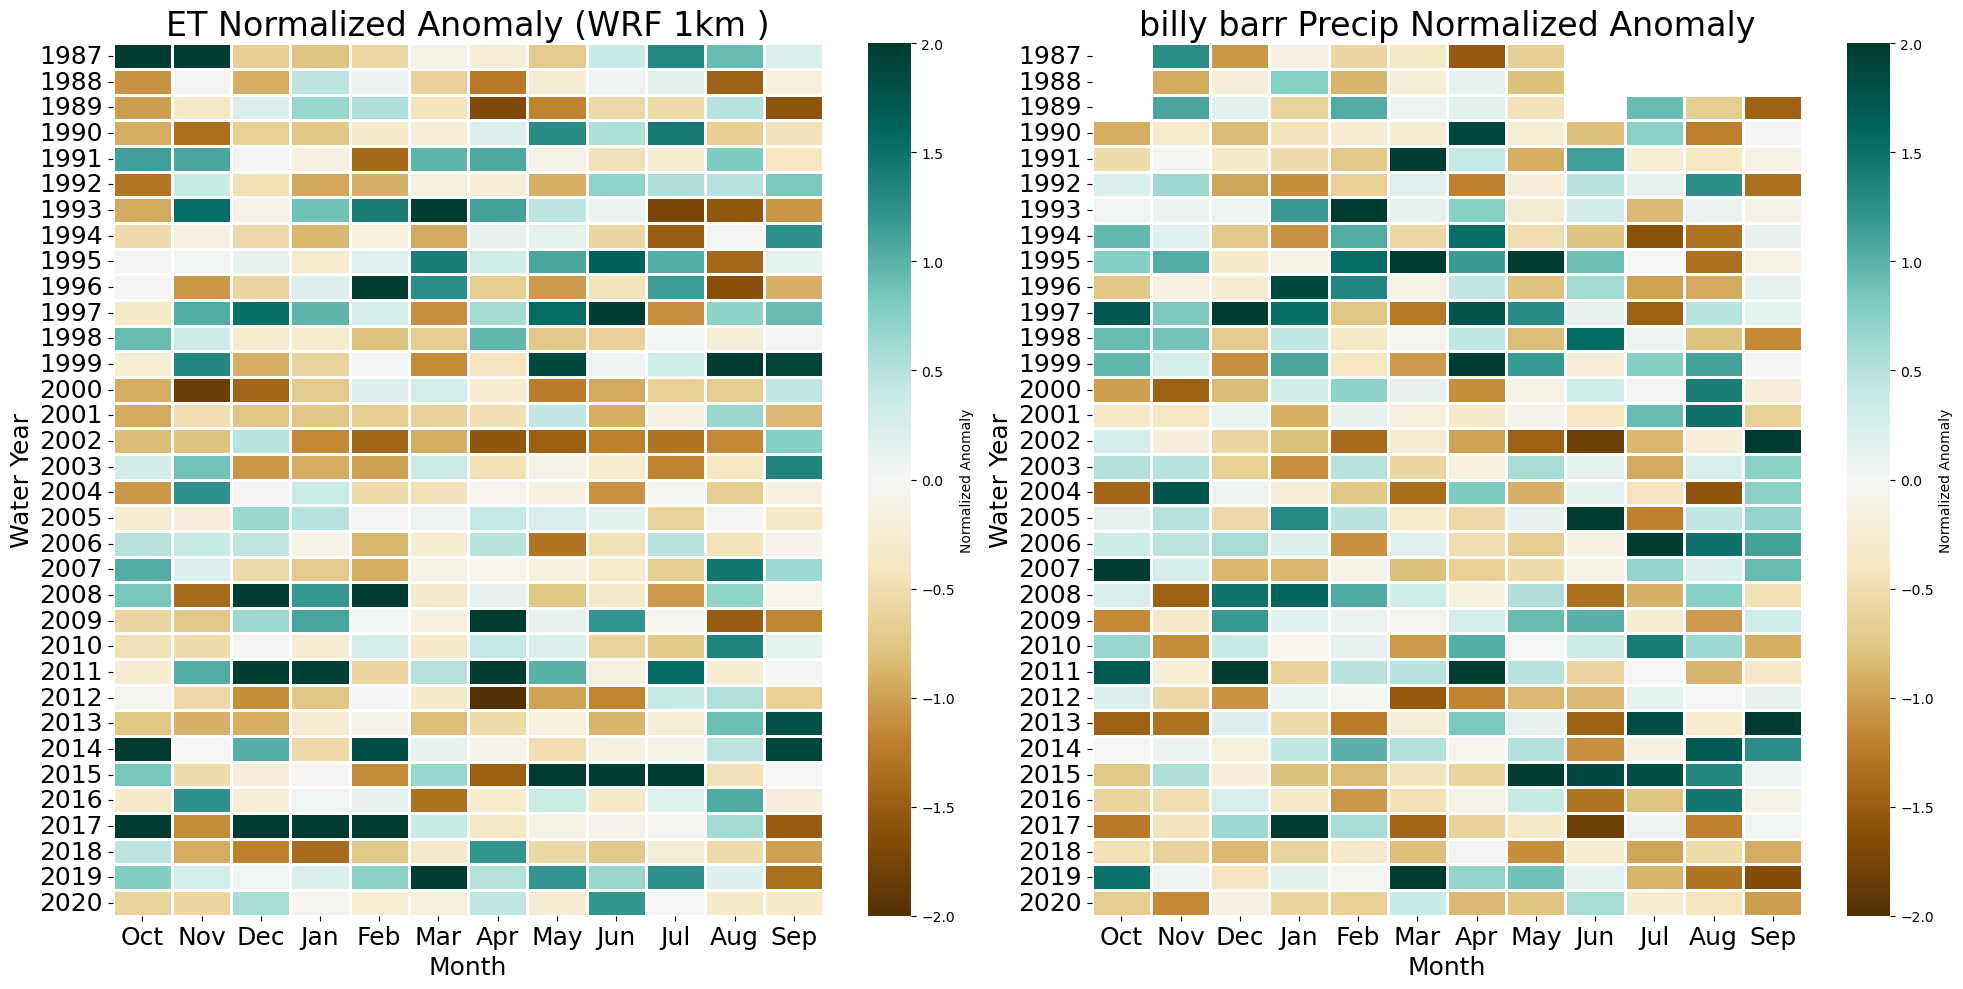

In [23]:
fig, axs=plt.subplots(ncols=2,figsize=(20,10), facecolor='w',tight_layout=True)

months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
sns.heatmap(precip_anomaly_df, cmap='BrBG', vmin=-2, vmax=2,linewidths=2, cbar_kws={'label':'Normalized Anomaly'}, ax=axs[0])
axs[0].set_yticklabels(et_anomaly_df.index, rotation=0, ha='right', size=18);
axs[0].set_xticklabels(months, rotation=0, ha='center', size=18);
axs[0].set_xlabel('Month',size=18)
axs[0].set_ylabel('Water Year', size=18)
axs[0].set_title('ET Normalized Anomaly (WRF 1km )', size=24)

months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
sns.heatmap(bb_precip_anomaly.loc[1987:2020], cmap='BrBG', vmin=-2,vmax=2,linewidths=2, cbar_kws={'label':'Normalized Anomaly'})
axs[1].set_yticklabels(bb_precip_anomaly.loc[1987:2020].index, rotation=0, ha='right', size=18);
axs[1].set_xticklabels(months, rotation=0, ha='center', size=18);
axs[1].set_xlabel('Month',size=18)
axs[1].set_ylabel('Water Year', size=18)
axs[1].set_title('billy barr Precip Normalized Anomaly', size=24)

In [ ]:
# make seasonal anomalies
# add up seasonal averages of ET and compare with streamflow for the years I have 

In [44]:
# Wrap it into a simple function
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    month_length = ds.XTIME.dt.days_in_month

    # Calculate the weighted average
    return (ds * month_length).resample(XTIME='QS-DEC').sum() / month_length.resample(XTIME='QS-DEC').sum()

In [46]:
wrf_climatology_ds_weighted = season_mean(wrf_climatology_ds).isel(XTIME=slice(1,137))
# wrf_climatology_ds_weighted.to_netcdf('/storage/dlhogan/sos/data/wrf_climatology_seasonal.nc')

### WRF vs billy barr comparison

In [ ]:
t1 = pd.date_range(start='2019-09-01',
                  end='2020-08-31',
                  freq='M')
t2 = pd.date_range(start='2019-9-01',
                  end='2020-08-31',
                  freq='M')

plt.plot(t2, wrf_climatology_ds.sel(south_north=54, west_east=20).where(wrf_climatology_ds.WY==1995).precip.dropna(dim='XTIME').cumsum(), label='WRF')
plt.plot(t1,(bb_monthly_precip*25.4).loc[1995].cumsum(), label='bb')
plt.legend()


In [4]:
cbrfc_sm = rioxr.open_rasterio('/storage/dlhogan/sos/data/cbrfc_fall_soil_product.nc')
cbrfc_sm = cbrfc_sm.rio.set_crs('EPSG:4326')
cbrfc_sm_rpj = cbrfc_sm.rio.reproject(upper_east_river_poly.crs, resampling=Resampling.cubic)
er_cbrfc_sm_rpj = cbrfc_sm_rpj.rio.clip(upper_east_river_poly.geometry)

# This part is more for fun if I want to get into evolational differences in precip, SWE, soil moisture and ET

In [27]:
aso_east_taylor_dem = rioxr.open_rasterio('/storage/dlhogan/sos/data/ASO/ASO_3M_PCDTM.001/2018.09.08/ASO_3M_PCDTM_USCOGE_20180908_20180913.tif').squeeze()
aso_east_dem = aso_east_taylor_dem.rio.clip(upper_east_river_poly.geometry)

In [39]:
aso_east_dem_2800_max = aso_east_dem.where((aso_east_dem <= 2800))
aso_east_dem_3000_max = aso_east_dem.where((aso_east_dem > 2800) & (aso_east_dem <= 3000))
aso_east_dem_3200_max = aso_east_dem.where((aso_east_dem > 3000) & (aso_east_dem <= 3200))
aso_east_dem_3400_max = aso_east_dem.where((aso_east_dem > 3200)&(aso_east_dem <= 3400))
aso_east_dem_3600_max = aso_east_dem.where((aso_east_dem > 3400)&(aso_east_dem <= 3600))
aso_east_dem_3800_max = aso_east_dem.where((aso_east_dem > 3600)&(aso_east_dem <= 3800))
aso_east_dem_4000_max = aso_east_dem.where((aso_east_dem > 3800))

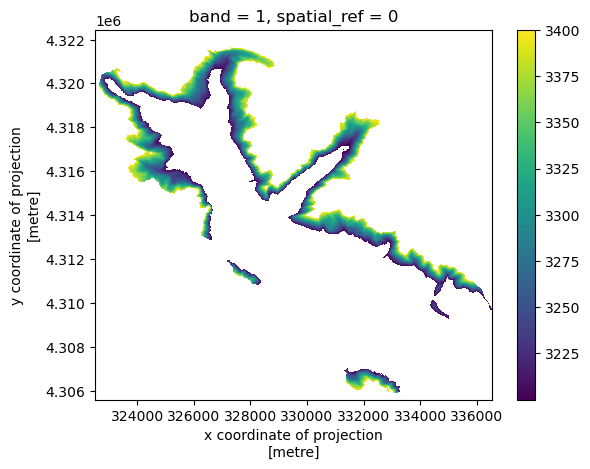

In [43]:
aso_east_dem_3400_max.plot()